In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
df=pd.read_json('transactions.txt',lines=True)

In [3]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [4]:
df.shape

(786363, 29)

In [5]:
df.dtypes

accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                       int64
enteredCVV                    int64
cardLast4Digits               int64
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd             object
expirationDateKeyInMatch    

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
null_counts = df.isnull().sum()
null_counts

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [8]:
empty_cells_count_per_column = df.apply(lambda x: x == '').sum()
empty_cells_count_per_column

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

In [9]:
df = df.drop(columns=['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'])

In [10]:
empty_cells_count_per_column = df.apply(lambda x: x == '').sum()
empty_cells_count_per_column

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

In [11]:
df.replace('', pd.NA, inplace=True)

# Remove rows with any NaN values
df.dropna(axis=0, how='any', inplace=True)

In [12]:
df.shape

(776668, 23)

In [13]:
empty_cells_count_per_column = df.apply(lambda x: x == '').sum()
empty_cells_count_per_column

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [14]:
df['accountNumber'].equals(df['customerId'])

True

In [15]:
df.drop(columns=['accountNumber'], inplace=True)

In [16]:
df['acqCountry'].value_counts()

acqCountry
US     769620
MEX      3110
CAN      2406
PR       1532
Name: count, dtype: int64

In [17]:
df['merchantName'].unique()

array(['Uber', 'AMC #191138', 'Play Store', ..., 'ATT #141119',
       'EZ Wireless #200746', 'Runners #747070'], dtype=object)

In [18]:
df['acqCountry'].equals(df['merchantCountryCode'])

False

In [19]:
df['posEntryMode'].unique()

array(['02', '09', '05', '80', '90'], dtype=object)

In [20]:
df['posConditionCode'].unique()

array(['01', '08', '99'], dtype=object)

In [21]:
df['merchantCategoryCode'].unique()

array(['rideshare', 'entertainment', 'mobileapps', 'fastfood',
       'food_delivery', 'auto', 'online_retail', 'gym', 'health',
       'personal care', 'food', 'fuel', 'online_subscriptions',
       'online_gifts', 'hotels', 'airline', 'furniture', 'subscriptions',
       'cable/phone'], dtype=object)

In [22]:
df['cardCVV'].equals(df['enteredCVV'])

False

In [23]:
df['isFraud'].unique()
df['isFraud'].value_counts()

isFraud
False    764702
True      11966
Name: count, dtype: int64

In [24]:
#Feature Engineering

In [25]:
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['day'] = df['transactionDateTime'].dt.day
df=df.drop(columns=['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange'])

In [26]:
df['transactionAmount_availableMoney_ratio'] = df['transactionAmount'] / df['availableMoney']

In [27]:
df.dtypes

customerId                                  int64
creditLimit                                 int64
availableMoney                            float64
transactionAmount                         float64
merchantName                               object
acqCountry                                 object
merchantCountryCode                        object
posEntryMode                               object
posConditionCode                           object
merchantCategoryCode                       object
cardCVV                                     int64
enteredCVV                                  int64
cardLast4Digits                             int64
transactionType                            object
currentBalance                            float64
cardPresent                                  bool
expirationDateKeyInMatch                     bool
isFraud                                      bool
day                                         int32
transactionAmount_availableMoney_ratio    float64


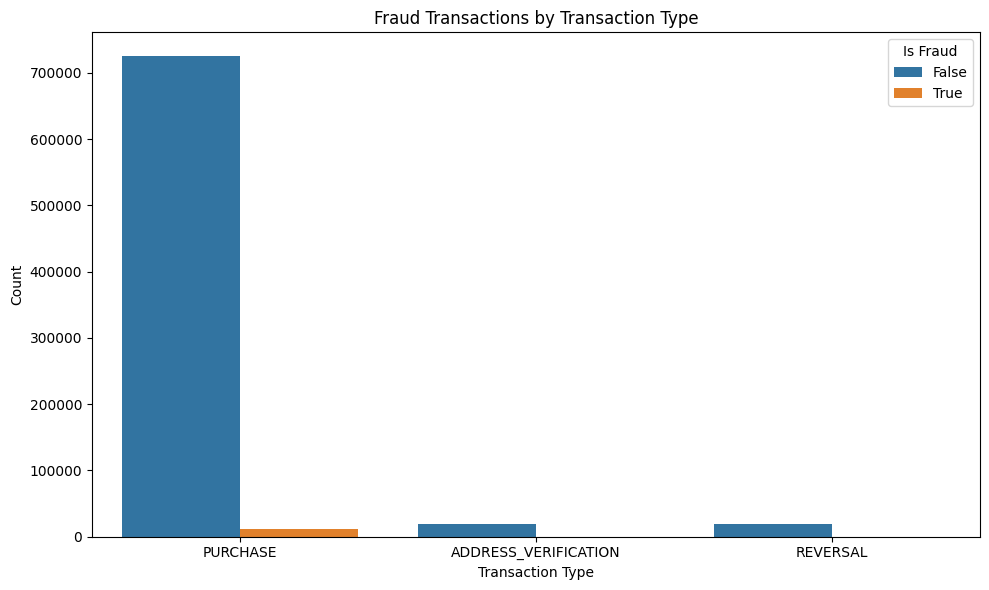

In [28]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='transactionType', hue='isFraud')
plt.title('Fraud Transactions by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend(title='Is Fraud', loc='upper right')

# Show plot
plt.tight_layout()
plt.show()

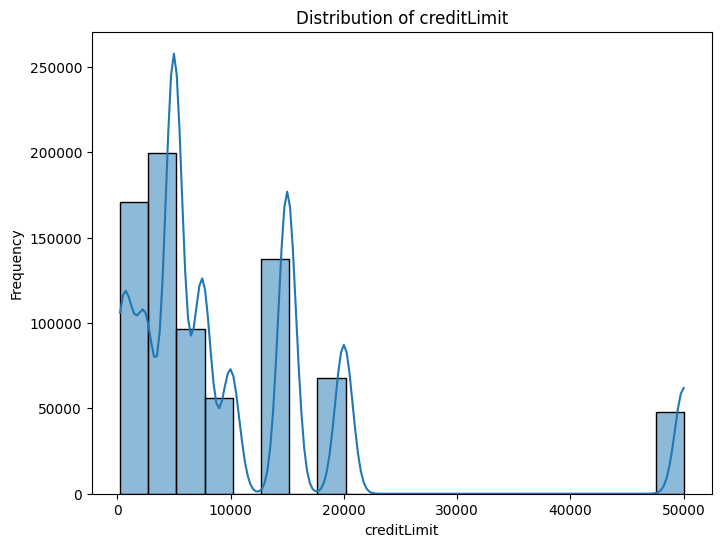

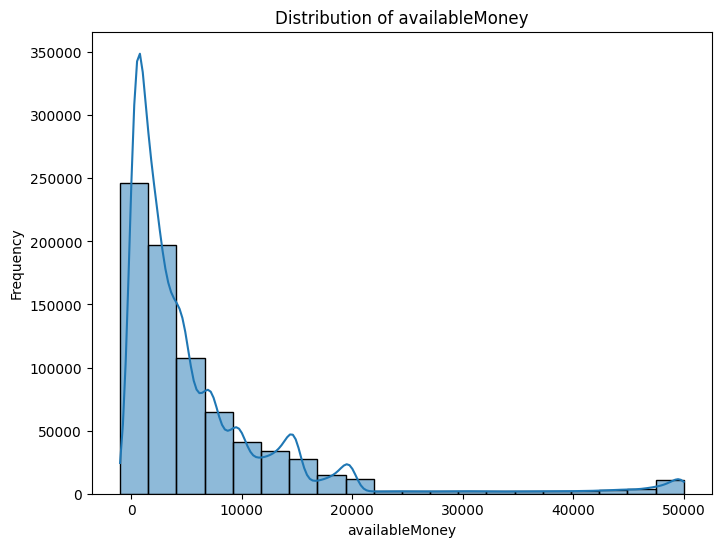

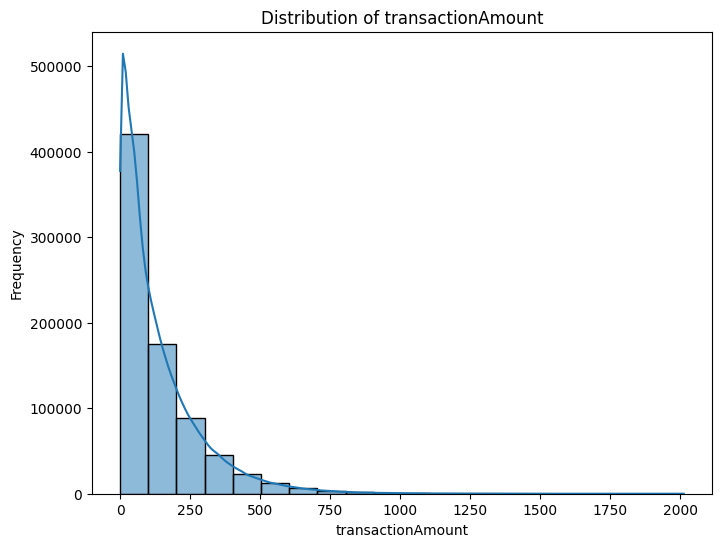

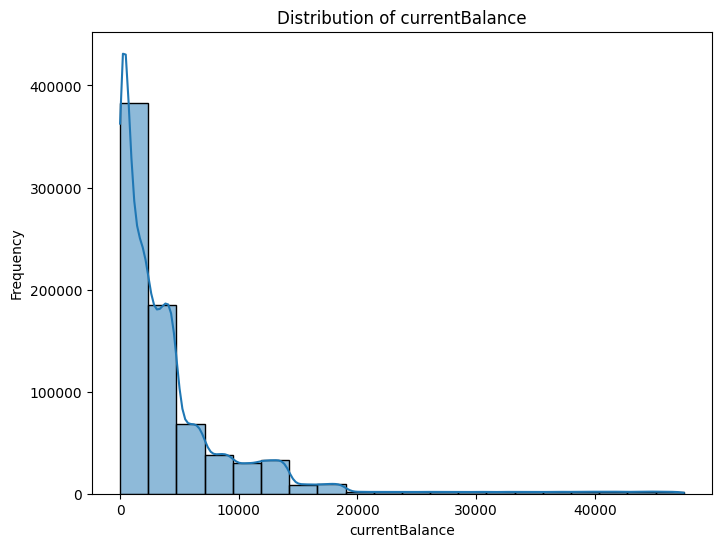

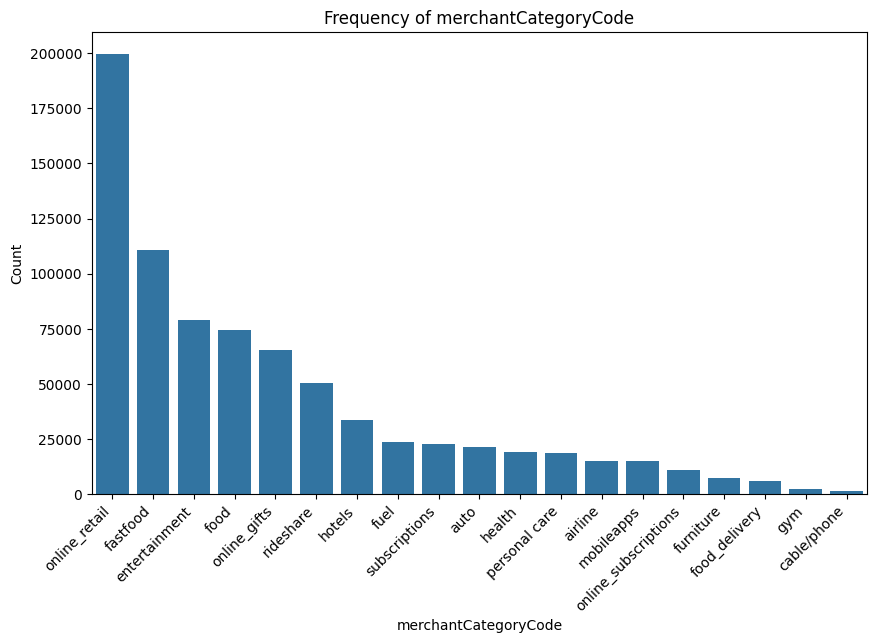

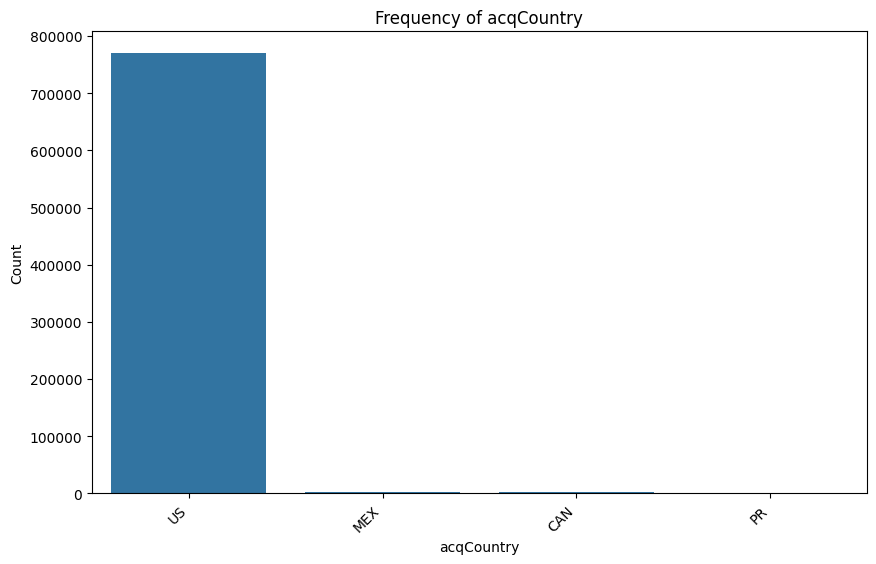

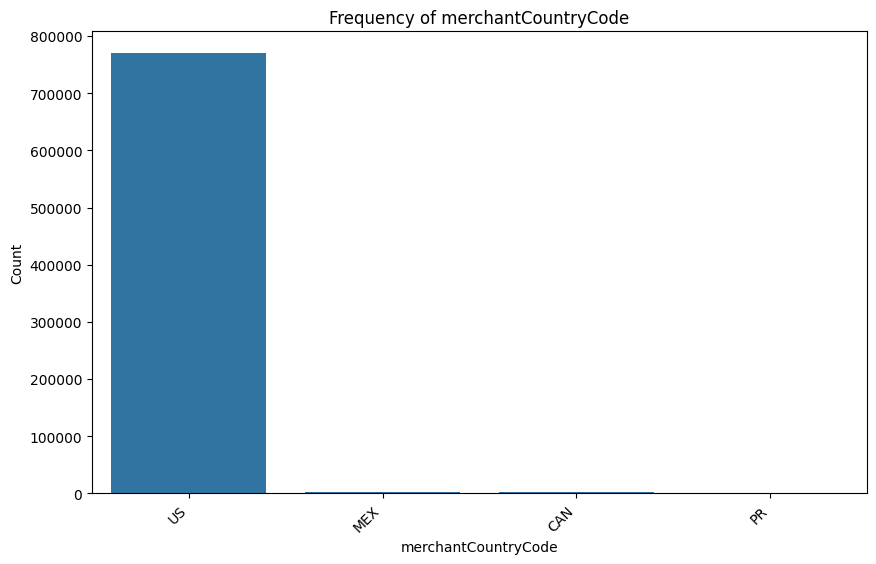

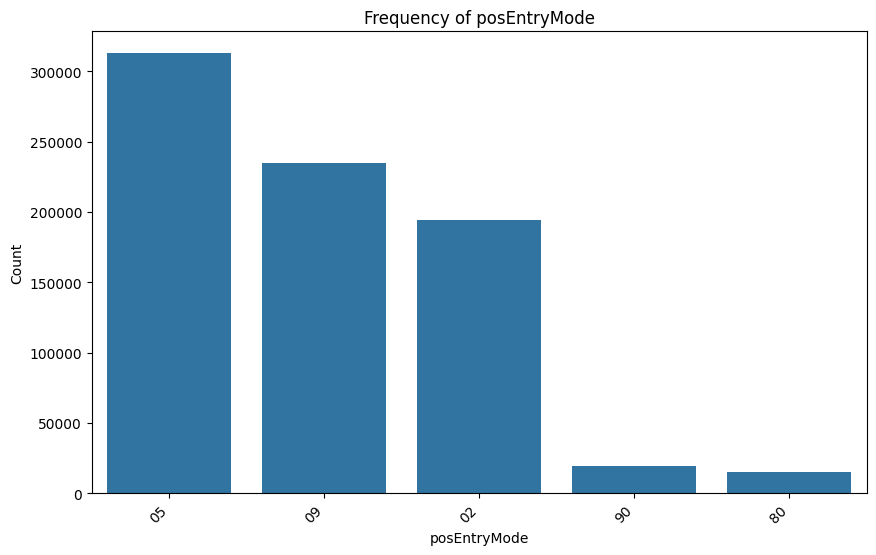

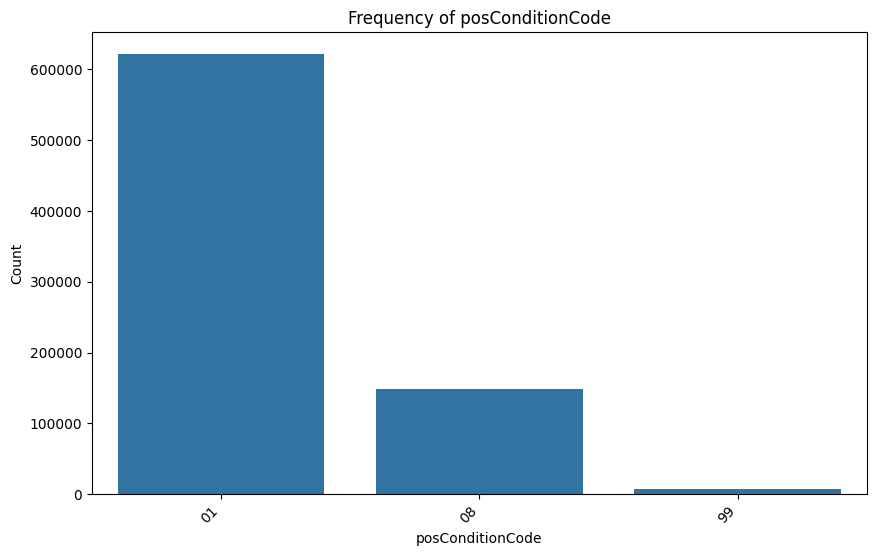

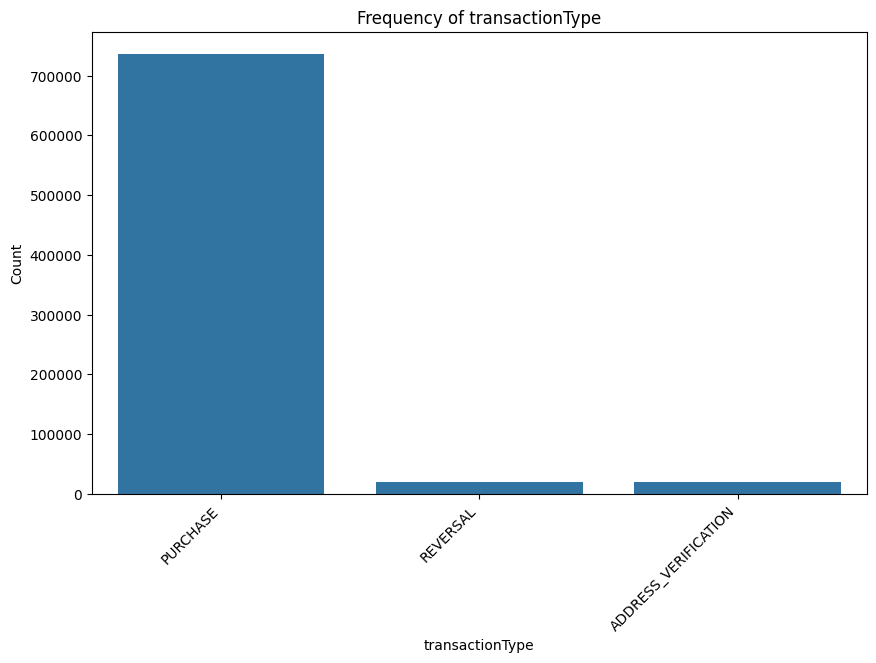

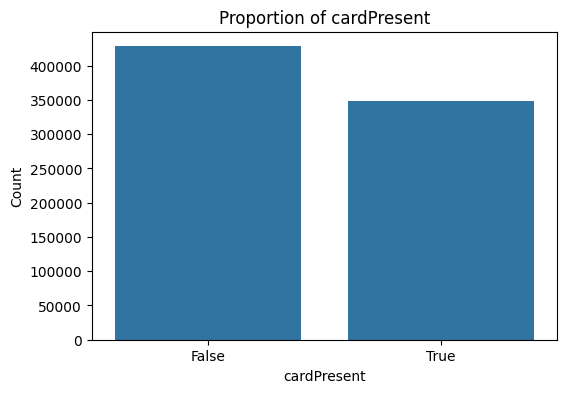

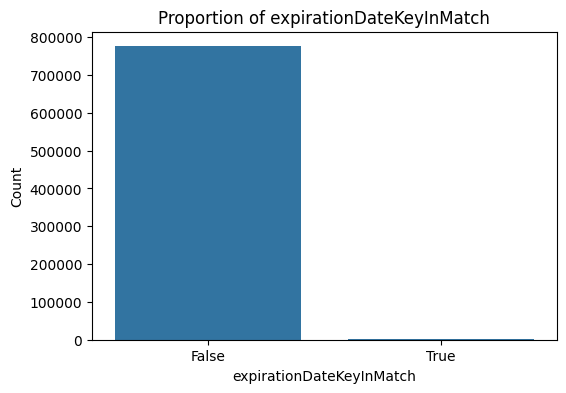

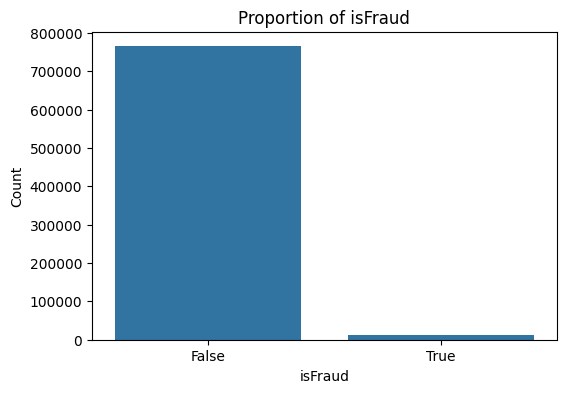

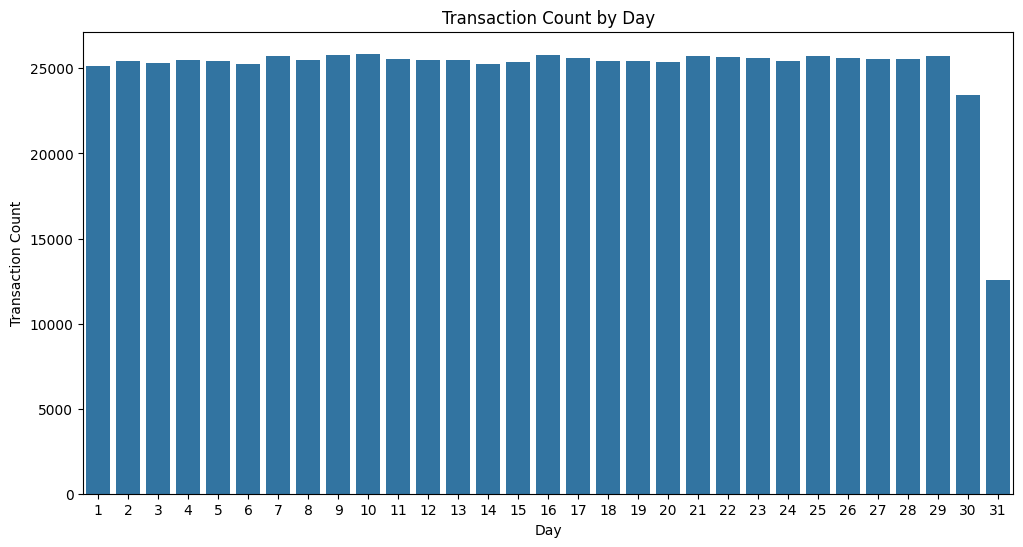

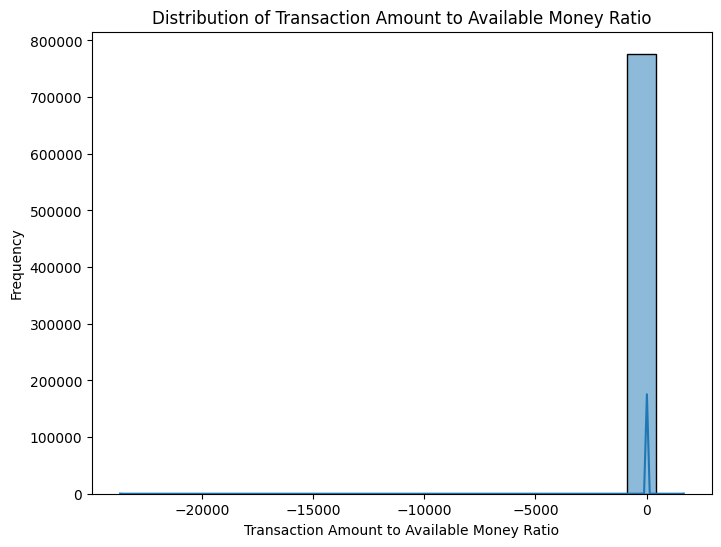

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your cleaned dataset is stored in a DataFrame called df

# Data Cleaning
# No further data cleaning is required since null values have been removed

# Visualization

# Numerical Columns
numerical_columns = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], bins=20, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Categorical Columns
categorical_columns = ['merchantCategoryCode', 'acqCountry', 'merchantCountryCode', 
                       'posEntryMode', 'posConditionCode', 'transactionType']
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f'Frequency of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Boolean Columns
boolean_columns = ['cardPresent', 'expirationDateKeyInMatch', 'isFraud']
for column in boolean_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=column)
    plt.title(f'Proportion of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# Day Column (Time Series Analysis)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='day')
plt.title('Transaction Count by Day')
plt.xlabel('Day')
plt.ylabel('Transaction Count')
plt.show()

# transactionAmount_availableMoney_ratio Column (Numerical Column)
plt.figure(figsize=(8, 6))
sns.histplot(df['transactionAmount_availableMoney_ratio'], bins=20, kde=True)
plt.title('Distribution of Transaction Amount to Available Money Ratio')
plt.xlabel('Transaction Amount to Available Money Ratio')
plt.ylabel('Frequency')
plt.show()


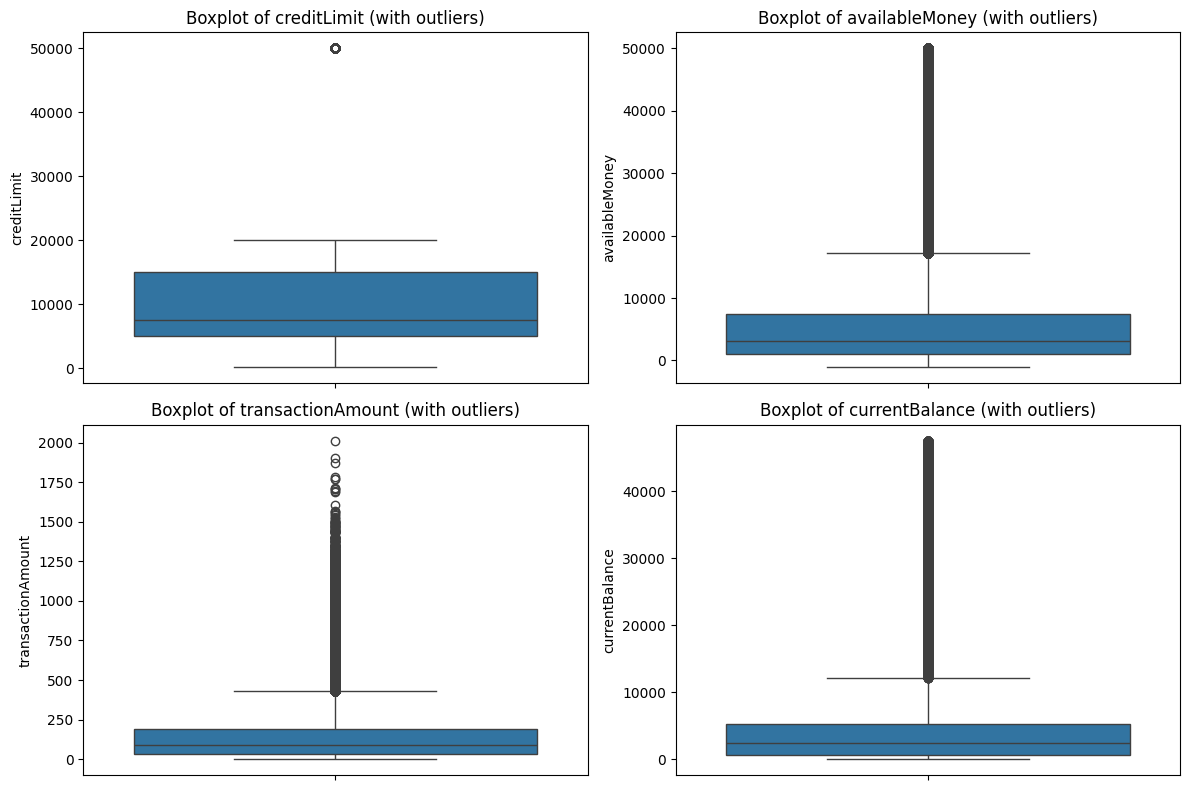


Handling outliers for column 'creditLimit':

Handling outliers for column 'availableMoney':

Handling outliers for column 'transactionAmount':

Handling outliers for column 'currentBalance':


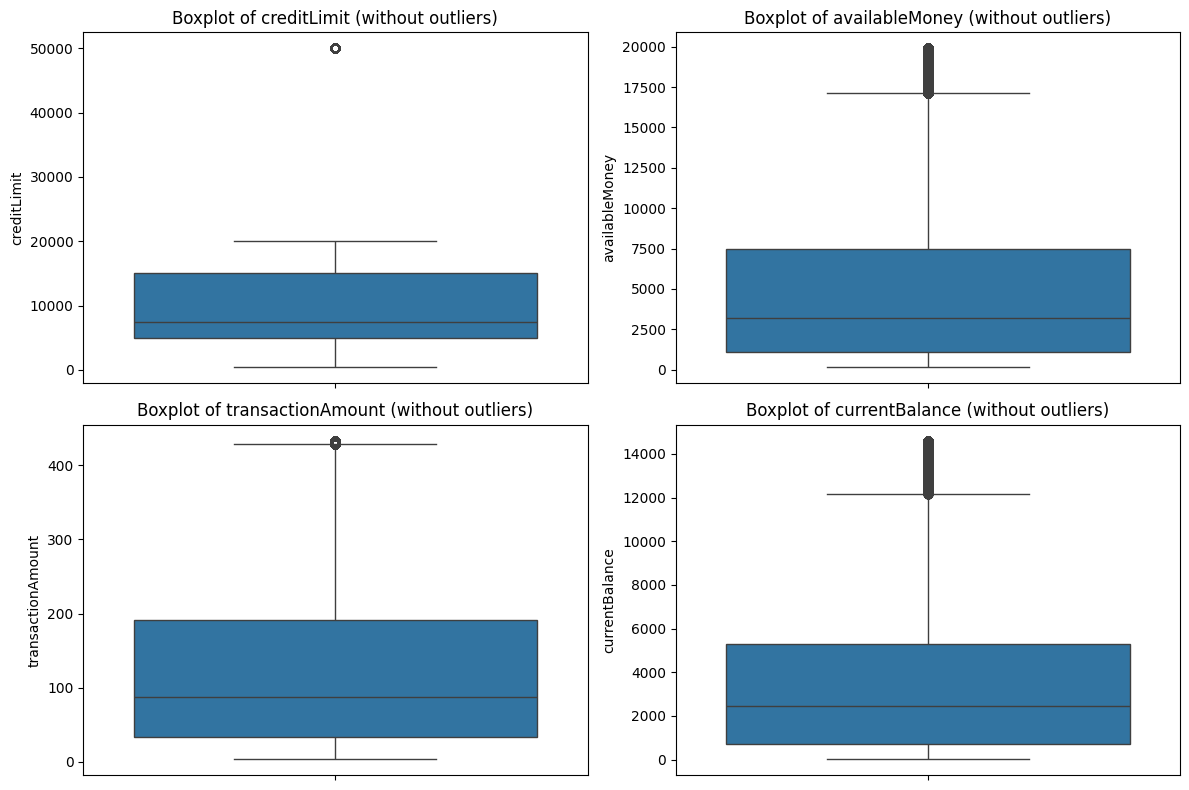

In [30]:
# winsorizing data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# Columns to handle outliers
numeric_columns = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']

plt.figure(figsize=(12, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y=column)
    plt.title(f'Boxplot of {column} (with outliers)')
plt.tight_layout()
plt.show()

# Winsorize each numeric column
for column in numeric_columns:
    print(f"\nHandling outliers for column '{column}':")
    # Winsorize the column
    winsorized_values = winsorize(df[column], limits=[0.05, 0.05])  # Adjust the limits as needed
    # Replace the column with winsorized values
    df[column] = winsorized_values

# Plot after winsorizing
plt.figure(figsize=(12, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y=column)
    plt.title(f'Boxplot of {column} (without outliers)')
plt.tight_layout()
plt.show()

# Save the cleaned DataFrame to a new CSV file if needed
# df.to_csv('cleaned_data.csv', index=False)


In [31]:
label_encoder = LabelEncoder()
columns_to_encode = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 
                     'posConditionCode', 'merchantCategoryCode', 'transactionType']
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

In [32]:
X = df.drop(columns = ['isFraud','merchantName','customerId'], axis=1)
y = df['isFraud']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
null_values = X_train.isnull().sum()
null_values

creditLimit                               0
availableMoney                            0
transactionAmount                         0
acqCountry                                0
merchantCountryCode                       0
posEntryMode                              0
posConditionCode                          0
merchantCategoryCode                      0
cardCVV                                   0
enteredCVV                                0
cardLast4Digits                           0
transactionType                           0
currentBalance                            0
cardPresent                               0
expirationDateKeyInMatch                  0
day                                       0
transactionAmount_availableMoney_ratio    0
dtype: int64

In [35]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [36]:
print("Class Distribution Before Resampling:")
print(y_train.value_counts())

Class Distribution Before Resampling:
isFraud
False    611806
True       9528
Name: count, dtype: int64


In [37]:
print("Class Distribution After Resampling:")
print(y_train_resampled.value_counts())

Class Distribution After Resampling:
isFraud
False    611806
True     611806
Name: count, dtype: int64


In [38]:
# Convert training and testing data to DMatrix with categorical support enabled
dtrain = xgb.DMatrix(data=X_train_resampled, label=y_train_resampled, enable_categorical=True)
dtest = xgb.DMatrix(data=X_test, label=y_test, enable_categorical=True)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',  # Binary classification problem
    'eval_metric': 'logloss'          # Evaluation metric
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
predictions = model.predict(dtest)

Accuracy: 0.8307646748297217
Precision: 0.041310870066928226
Recall: 0.44052502050861364
F1-score: 0.07553805035870025
ROC-AUC Score: 0.7118750659404723


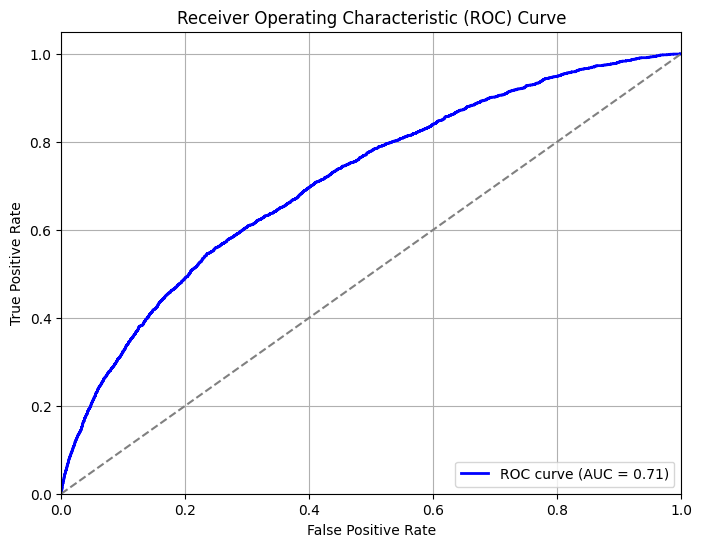

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
# Convert probabilities to binary predictions
binary_predictions = np.round(predictions)

# Calculate evaluation metrics with binary predictions
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)
roc_auc = roc_auc_score(y_test, predictions)  # Note: ROC-AUC can handle continuous probabilities

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC Score:", roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [40]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Convert DataFrame to DMatrix
dtrain = xgb.DMatrix(X_train)
dtest = xgb.DMatrix(X_test)

# Compute training accuracy
train_accuracy = accuracy_score(y_train, np.round(model.predict(dtrain)))

# Compute test accuracy
test_accuracy = accuracy_score(y_test, np.round(model.predict(dtest)))

# Generate confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train, np.round(model.predict(dtrain)))

# Generate confusion matrix for testing data
test_conf_matrix = confusion_matrix(y_test, np.round(model.predict(dtest)))

# Print training and test accuracies
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Print confusion matrices
print("\nConfusion Matrix for Training Data:")
print(train_conf_matrix)
print("\nConfusion Matrix for Testing Data:")
print(test_conf_matrix)


Training Accuracy: 0.8332619814785607
Test Accuracy: 0.8307646748297217

Confusion Matrix for Training Data:
[[512829  98977]
 [  4623   4905]]

Confusion Matrix for Testing Data:
[[127972  24924]
 [  1364   1074]]


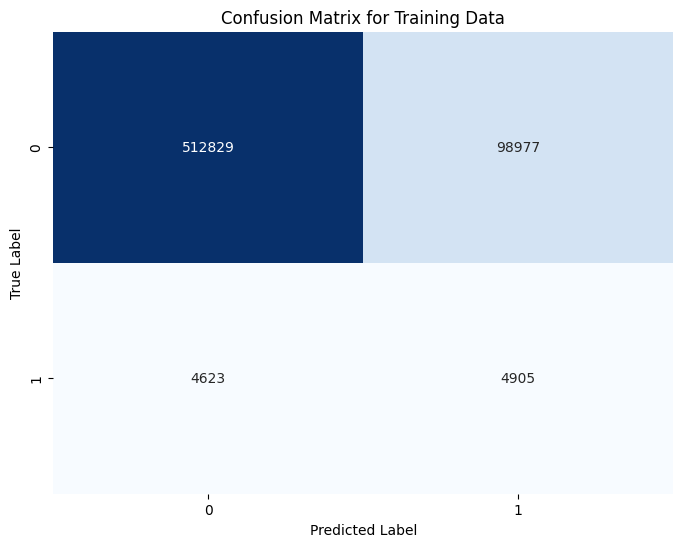

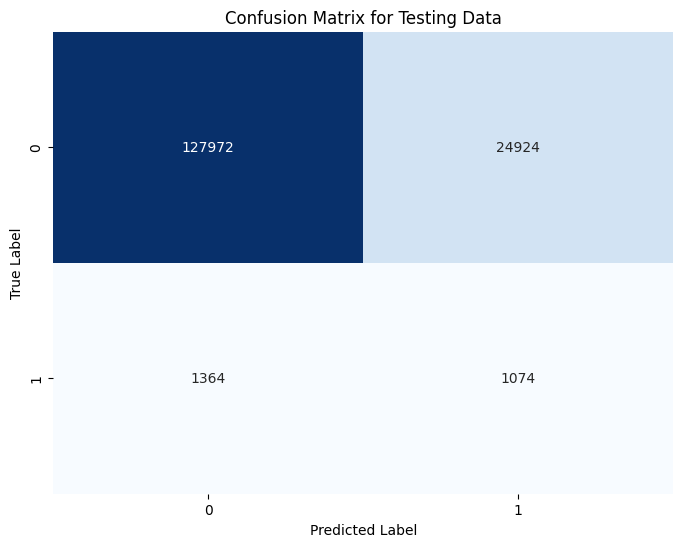

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot confusion matrix for training data
plot_confusion_matrix(train_conf_matrix, 'Confusion Matrix for Training Data')

# Plot confusion matrix for testing data
plot_confusion_matrix(test_conf_matrix, 'Confusion Matrix for Testing Data')


In [42]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the Random Forest model
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
rf_predictions = rf_classifier.predict(X_test)


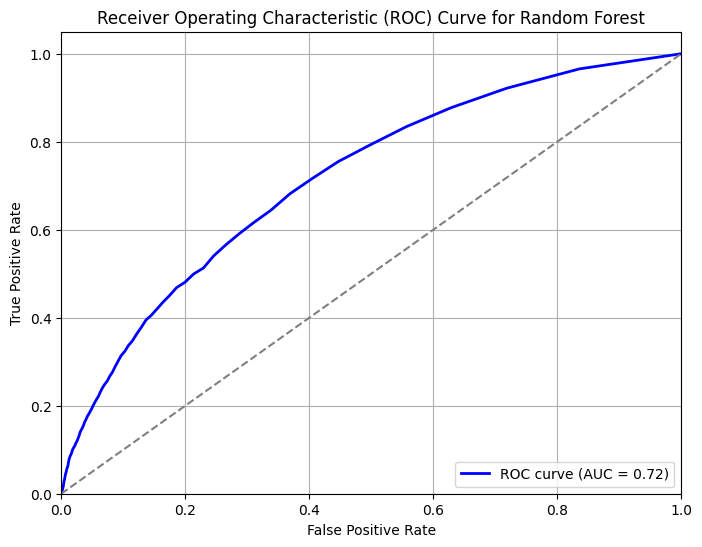

Accuracy: 0.9579615538130738
Precision: 0.06817222456732798
Recall: 0.1324856439704676
F1-score: 0.09002229654403568
ROC-AUC Score: 0.5518049034000517


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate probabilities for positive class
rf_probs = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_probs)

# Calculate the area under the ROC curve (AUC)
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate evaluation metrics for Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_predictions)
print("Accuracy:",rf_accuracy)
print("Precision:",rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)
print("ROC-AUC Score:", rf_roc_auc)



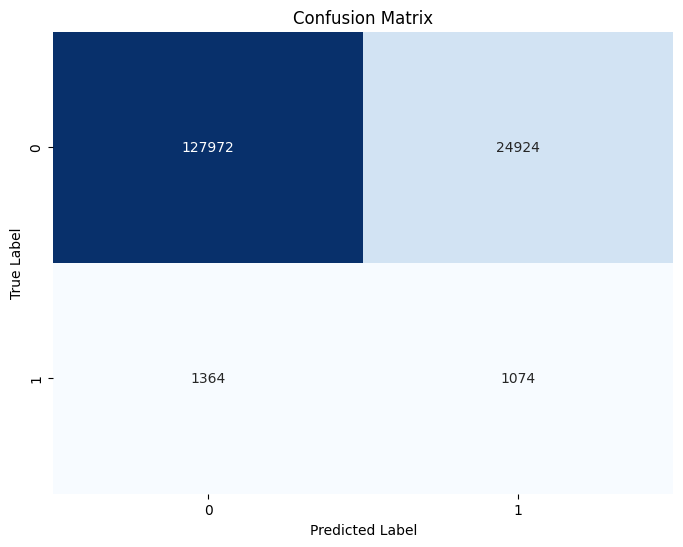

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [45]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the Gradient Boosting model
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
gb_predictions = gb_classifier.predict(X_test)


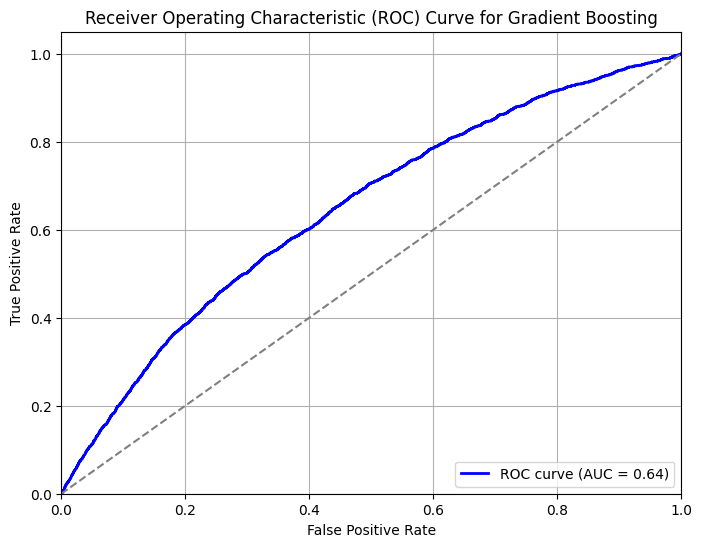

Accuracy: 0.7141256904476805
Precision: 0.026790546635395995
Recall: 0.48728465955701394
F1-score: 0.050788764909580605
ROC-AUC Score: 0.6025137194813115


In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate probabilities for positive class
gb_probs = gb_classifier.predict_proba(X_test)[:, 1]

# Calculate false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb_probs)

# Calculate the area under the ROC curve (AUC)
gb_roc_auc = auc(gb_fpr, gb_tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(gb_fpr, gb_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate evaluation metrics for Gradient Boosting
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_precision = precision_score(y_test, gb_predictions)
gb_recall = recall_score(y_test, gb_predictions)
gb_f1 = f1_score(y_test, gb_predictions)
gb_roc_auc = roc_auc_score(y_test, gb_predictions)
print("Accuracy:",gb_accuracy)
print("Precision:",gb_precision)
print("Recall:", gb_recall)
print("F1-score:", gb_f1)
print("ROC-AUC Score:", gb_roc_auc)

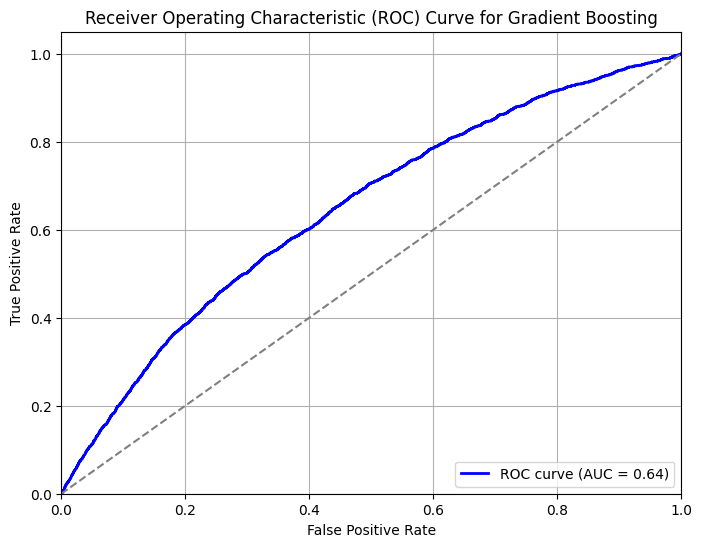

Accuracy: 0.7141256904476805
Precision: 0.026790546635395995
Recall: 0.48728465955701394
F1-score: 0.050788764909580605
ROC-AUC Score: 0.6025137194813115


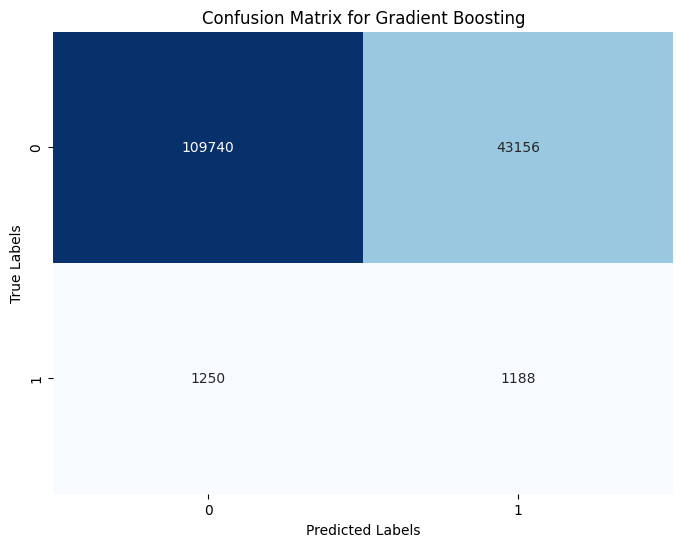

In [47]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate probabilities for positive class
gb_probs = gb_classifier.predict_proba(X_test)[:, 1]

# Calculate false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb_probs)

# Calculate the area under the ROC curve (AUC)
gb_roc_auc = auc(gb_fpr, gb_tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(gb_fpr, gb_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate evaluation metrics for Gradient Boosting
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_precision = precision_score(y_test, gb_predictions)
gb_recall = recall_score(y_test, gb_predictions)
gb_f1 = f1_score(y_test, gb_predictions)
gb_roc_auc = roc_auc_score(y_test, gb_predictions)
print("Accuracy:", gb_accuracy)
print("Precision:", gb_precision)
print("Recall:", gb_recall)
print("F1-score:", gb_f1)
print("ROC-AUC Score:", gb_roc_auc)

# Generate confusion matrix
cm = confusion_matrix(y_test, gb_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()


In [48]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the training data using RandomUnderSampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


In [49]:
print("Class Distribution Before Resampling:")
print(y_train.value_counts())

Class Distribution Before Resampling:
isFraud
False    611806
True       9528
Name: count, dtype: int64


In [50]:
print("Class Distribution After Resampling:")
print(y_train_resampled.value_counts())

Class Distribution After Resampling:
isFraud
False    9528
True     9528
Name: count, dtype: int64


In [51]:
# Convert training and testing data to DMatrix with categorical support enabled
dtrain = xgb.DMatrix(data=X_train_resampled, label=y_train_resampled, enable_categorical=True)
dtest = xgb.DMatrix(data=X_test, label=y_test, enable_categorical=True)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',  # Binary classification problem
    'eval_metric': 'logloss'          # Evaluation metric
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
predictions = model.predict(dtest)

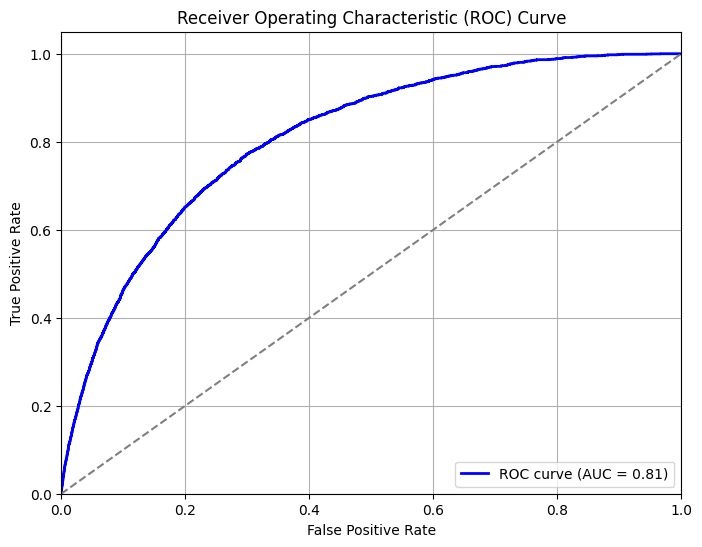

Accuracy: 0.7234926030360385
Precision: 0.04122030213122551
Recall: 0.7465135356849877
F1-score: 0.07812667682599644
ROC-AUC Score: 0.8099395164371086


In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Convert probabilities to binary predictions
binary_predictions = np.round(predictions)

# Calculate evaluation metrics with binary predictions
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)
roc_auc = roc_auc_score(y_test, predictions)  # Note: ROC-AUC can handle continuous probabilities
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC Score:", roc_auc)


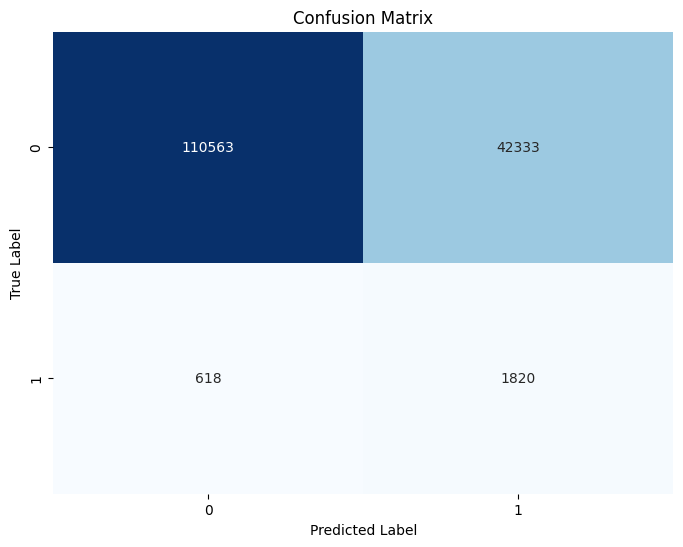

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [54]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    # Add more hyperparameters to tune as needed
}

# Initialize the GridSearchCV object with the XGBoost classifier, parameter grid, and evaluation metric
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
                           param_grid=param_grid,
                           scoring='precision',
                           cv=3)  # Use 3-fold cross-validation

# Perform the grid search
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters found by grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new XGBoost model with the best hyperparameters
best_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', **best_params)
best_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set using the tuned model
tuned_predictions = best_model.predict(X_test)

# Calculate precision with the tuned model
tuned_precision = precision_score(y_test, tuned_predictions)

# Print precision with the tuned model
print("Precision with Tuned Model:", tuned_precision)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
Precision with Tuned Model: 0.04198672356567094


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
Accuracy: 0.7355633666808297
Precision: 0.04198672356567094
Recall: 0.7264150943396226
F1-score: 0.07938500156887354
ROC-AUC Score: 0.8056997479517999
PR AUC Score: 0.06856605366854192


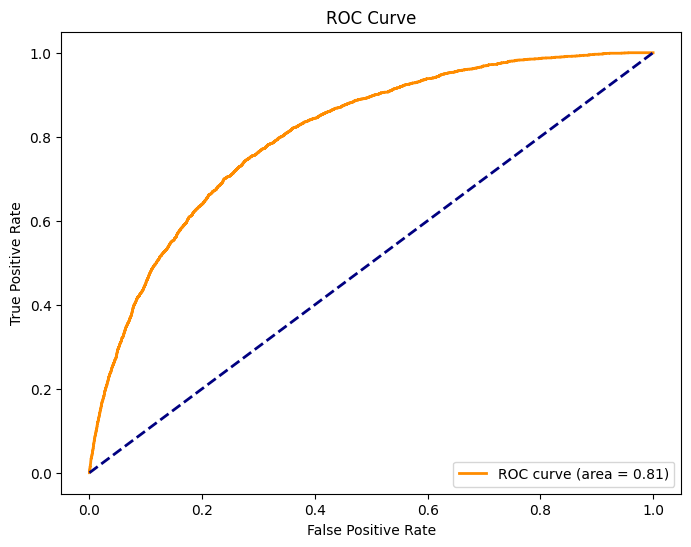

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# Define the parameter grid to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    # Add more hyperparameters to tune as needed
}

# Initialize the GridSearchCV object with the XGBoost classifier, parameter grid, and evaluation metric
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
                           param_grid=param_grid,
                           scoring='precision',
                           cv=3)  # Use 3-fold cross-validation

# Perform the grid search
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters found by grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new XGBoost model with the best hyperparameters
best_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', **best_params)
best_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set using the tuned model
tuned_predictions = best_model.predict(X_test)
tuned_probabilities = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, tuned_predictions)
precision = precision_score(y_test, tuned_predictions)
recall = recall_score(y_test, tuned_predictions)
f1 = f1_score(y_test, tuned_predictions)
roc_auc = roc_auc_score(y_test, tuned_probabilities)
pr_auc = average_precision_score(y_test, tuned_probabilities)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC Score:", roc_auc)
print("PR AUC Score:", pr_auc)


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, tuned_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    # Add more hyperparameters to tune as needed
}

# Initialize the GridSearchCV object with the XGBoost classifier, parameter grid, and evaluation metric
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
                           param_grid=param_grid,
                           scoring='precision',
                           cv=3)  # Use 3-fold cross-validation

# Perform the grid search
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters found by grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new XGBoost model with the best hyperparameters
best_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', **best_params)
best_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set using the tuned model
tuned_predictions = best_model.predict(X_test)
tuned_probabilities = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, tuned_predictions)
precision = precision_score(y_test, tuned_predictions)
recall = recall_score(y_test, tuned_predictions)
f1 = f1_score(y_test, tuned_predictions)
roc_auc = roc_auc_score(y_test, tuned_probabilities)
pr_auc = average_precision_score(y_test, tuned_probabilities)

# Print evaluation metrics for test data
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC-AUC Score:", roc_auc)
print("Test PR AUC Score:", pr_auc)

# Generate confusion matrix for test data
test_conf_matrix = confusion_matrix(y_test, tuned_predictions)
print("\nConfusion Matrix for Testing Data:")
print(test_conf_matrix)

# Make predictions on the training set using the tuned model
tuned_train_predictions = best_model.predict(X_train_resampled)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_resampled, tuned_train_predictions)

# Print evaluation metrics for training data
print("\nTraining Accuracy:", train_accuracy)

# Generate confusion matrix for training data
train_conf_matrix = confusion_matrix(y_train_resampled, tuned_train_predictions)
print("\nConfusion Matrix for Training Data:")
print(train_conf_matrix)



Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
Test Accuracy: 0.7355633666808297
Test Precision: 0.04198672356567094
Test Recall: 0.7264150943396226
Test F1-score: 0.07938500156887354
Test ROC-AUC Score: 0.8056997479517999
Test PR AUC Score: 0.06856605366854192

Confusion Matrix for Testing Data:
[[112487  40409]
 [   667   1771]]

Training Accuracy: 0.764850965575147

Confusion Matrix for Training Data:
[[7315 2213]
 [2268 7260]]


In [57]:
# Adjust parameters based on the best hyperparameters found
params['learning_rate'] = 0.1  # Decrease learning rate
params['max_depth'] = 7         # Increase max depth
params['subsample'] = 0.9       # Decrease subsample

# Retrain the model with adjusted parameters
model_adjusted = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set with the adjusted model
predictions_adjusted = model_adjusted.predict(dtest)

# Convert probabilities to binary predictions
binary_predictions_adjusted = np.round(predictions_adjusted)

# Calculate precision with the adjusted model
precision_adjusted = precision_score(y_test, binary_predictions_adjusted)

# Print precision with the adjusted model
print("Precision with Adjusted Model:", precision_adjusted)


Precision with Adjusted Model: 0.042154401932956435


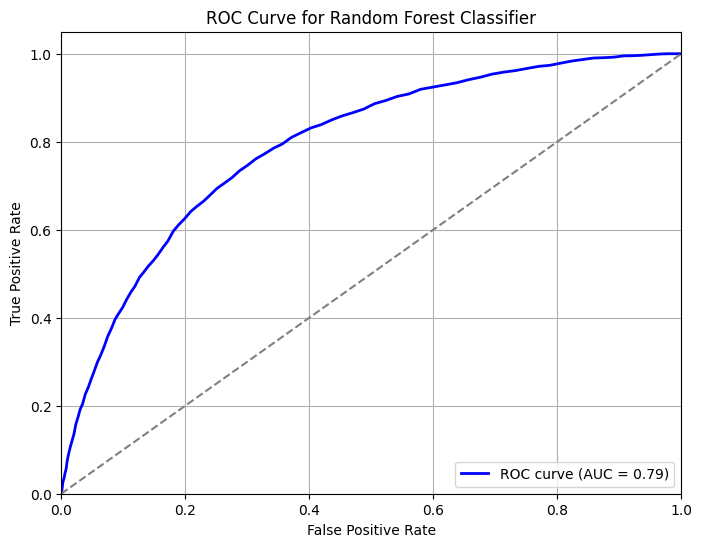

Accuracy: 0.7363745219977597
Precision: 0.041021118367736094
Recall: 0.7059064807219032
F1-score: 0.07753649306181294
ROC-AUC Score: 0.721383415120265


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the Random Forest model
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
rf_predictions = rf_classifier.predict(X_test)

# Calculate evaluation metrics for Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_predictions)

# Plot ROC curve
rf_probs = rf_classifier.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)
print("ROC-AUC Score:", rf_roc_auc)


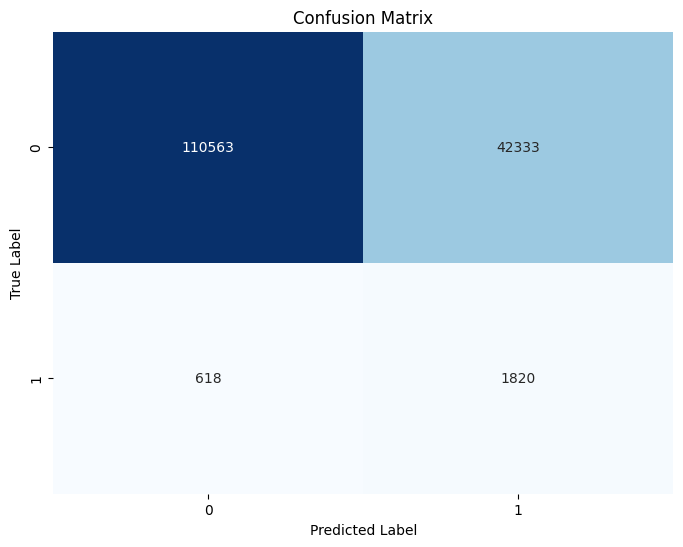

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


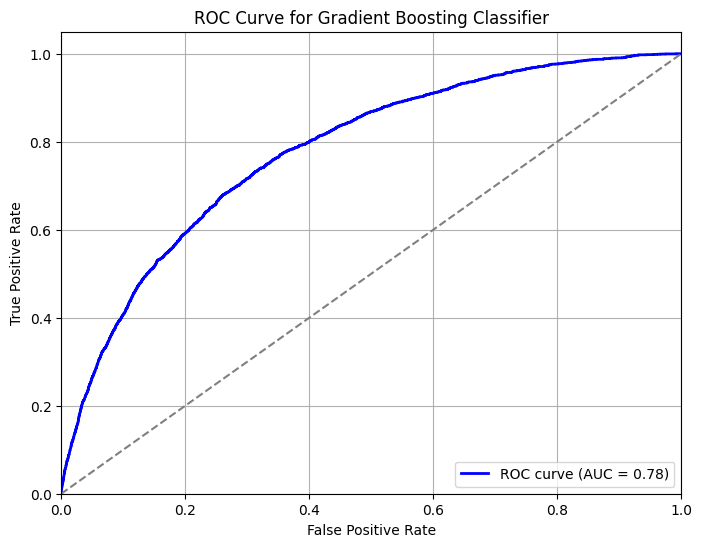

Accuracy: 0.7244067622027374
Precision: 0.03854330978670873
Recall: 0.6915504511894995
F1-score: 0.0730170416405015
ROC-AUC Score: 0.7082405615093583


In [60]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the Gradient Boosting model
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
gb_predictions = gb_classifier.predict(X_test)

# Calculate evaluation metrics for Gradient Boosting
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_precision = precision_score(y_test, gb_predictions)
gb_recall = recall_score(y_test, gb_predictions)
gb_f1 = f1_score(y_test, gb_predictions)
gb_roc_auc = roc_auc_score(y_test, gb_predictions)

# Plot ROC curve
gb_probs = gb_classifier.predict_proba(X_test)[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
gb_auc = auc(gb_fpr, gb_tpr)

plt.figure(figsize=(8, 6))
plt.plot(gb_fpr, gb_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % gb_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Accuracy:", gb_accuracy)
print("Precision:", gb_precision)
print("Recall:", gb_recall)
print("F1-score:", gb_f1)
print("ROC-AUC Score:", gb_roc_auc)


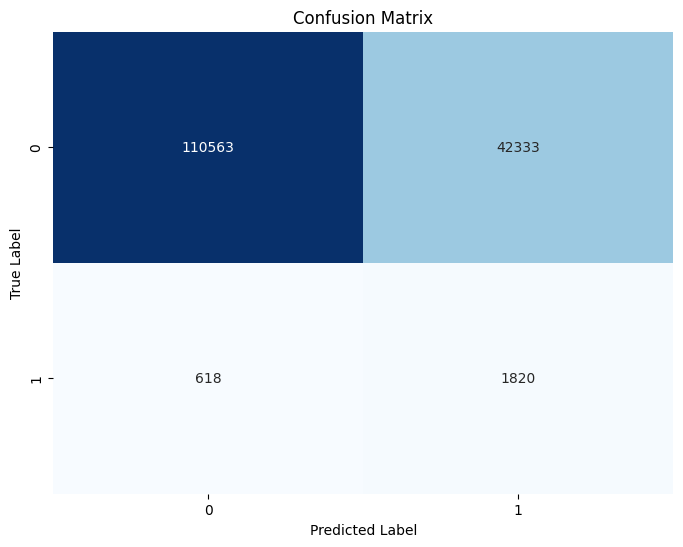

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
